# Live cu-inj-live-impact 

In [1]:
# Setup directories, and convert dashboard notebook to a script for importing
!./setup.bash

[NbConvertApp] Converting notebook make_dashboard.ipynb to script
[NbConvertApp] Writing 3662 bytes to make_dashboard.py


In [2]:
from impact import evaluate_impact_with_distgen, run_impact_with_distgen
from impact.tools import isotime
from impact.evaluate import  default_impact_merit
from impact import Impact

from make_dashboard import make_dashboard

In [3]:
import pandas as pd

import json
import epics

import os
from time import sleep, time

# Nicer plotting
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.use('Agg')

%config InlineBackend.figure_format = 'retina'

In [4]:
ROOT = os.getcwd()

# Configuration

In [5]:
PREFIX = 'cu-inj-live-impact'

# Directory for summary output
OUTPUTDIR = os.path.join(ROOT, 'output')

# Directory to output plots
PLOTDIR = os.path.join(ROOT, 'plot')

# Directory for archive files
APATH = os.path.join(ROOT, 'archive')


# PV -> Sim conversion table
CSV =  'pv_mapping/cu_inj_impact.csv'

# Base input files
CONFIG0 = {'impact_config': os.path.expandvars('$LCLS_LATTICE/impact/models/cu_inj/ImpactT.yaml'),
          'distgen_input_file': os.path.expandvars('$LCLS_LATTICE/distgen/models/cu_inj/distgen.yaml')
         }

# Base settings
SETTINGS0 = {
 'distgen:t_dist:length:value': 4 * 1.65 ,     #  Inferred pulse stacker FWHM: 4 ps, converted to tukey length
 'distgen:n_particle': 10000,   
 'stop': 16.5, 
 'timeout': 100000,
 'header:Nx': 32,
 'header:Ny': 32,
 'header:Nz': 32,
 #'total_charge':0, # Set to 0 to turn off Space Charge for faster execution 
 'change_timestep_1:dt':4e-12, 
 
 # Parallel control
 'header:Nprow':4,
 'header:Npcol':4,
 'use_mpi':True
   }

# EPICS -> Simulation settings

In [6]:
IRIS_DIAMETER_FROM_ENUM_IN_MM = {0:'LCLS', # LCLS cutout picture
       1 :1.8 ,
       2 :1.6 ,
       3 :1.4 ,
       4 :1.2 ,
       5 :1.1 ,
       6 :1.0 ,
       7 :0.8 ,
       8 :0.6 ,
       9 :0.5 ,
       10: 0.4 , 
       11: 0.3 }

def get_live_settings(csv, base_settings={}):
    """
    Fetches live settings for all devices in the CSV table, and translates them to simulation inputs
     
    """
    df = pd.read_csv(csv)
    pv_names = list(df['device_pv_name'])
    
    df['pv_value'] = epics.caget_many(pv_names)
    df.set_index('device_pv_name', inplace=True)
    
    # Custom for enum
    iris_enum = int(df.at['IRIS:LR20:130:CONFG_SEL', 'pv_value'])
    df.at['IRIS:LR20:130:CONFG_SEL', 'pv_value'] = IRIS_DIAMETER_FROM_ENUM_IN_MM[iris_enum]
    
    # Assign impact
    df['impact_value'] = df['impact_factor']*df['pv_value'] 
    
    # Collect settings
    settings = base_settings.copy()
    settings.update(dict(zip(df['impact_name'], df['impact_value'])))

    return settings, df

LIVE_SETTINGS, DF = get_live_settings(CSV, SETTINGS0)
DF[['Variable', 'bmad_name', 'pv_value','pv_unit',  'device_min', 'device_max',  'impact_name', 'impact_factor', 'impact_unit',
       'impact_description',  'impact_value']]

,Variable,bmad_name,pv_value,pv_unit,device_min,device_max,impact_name,impact_factor,impact_unit,impact_description,impact_value
device_pv_name,,,,,,,,,,,
IRIS:LR20:130:CONFG_SEL,Iris diameter ENUM,NaN,1.200000,mm,0.300,1.800,distgen:r_dist:sigma_xy:value,0.333333,mm,Gaussian is cut off at 1.5 sigma_xu,4.000000e-01
SOLN:IN20:121:BDES,Solenoid,SOL1,0.463741,kG*m,0.000,0.550,SOL1:solenoid_field_scale,0.514272,T,peak field,2.384891e-01
QUAD:IN20:121:BDES,Corrector quad,CQ01,0.007361,kG,-0.015,0.015,CQ01:b1_gradient,-0.476190,T/m,Corrector quad gradient,-3.505394e-03
QUAD:IN20:122:BDES,Skew quad,SQ01,0.002242,kG,-0.015,0.015,SQ01:b1_gradient,-0.476190,T/m,Skew quad gradient,-1.067800e-03
ACCL:IN20:300:L0A_PDES,L0A phase,L0A,0.000000,deg,-20.000,0.000,L0A_phase:dtheta0_deg,1.000000,deg,Phase relative to on-crest,0.000000e+00
ACCL:IN20:400:L0B_PDES,L0B phase,L0B,-2.500000,deg,-20.000,0.000,L0B_phase:dtheta0_deg,1.000000,deg,Phase relative to on-crest,-2.500000e+00
ACCL:IN20:300:L0A_ADES,L0B voltage,L0A,58.000000,MV,0.000,110.000,L0A_scale:voltage,1000000.000000,V,Voltage,5.800000e+07
ACCL:IN20:400:L0B_ADES,L0B voltage,L0B,70.907612,MV,0.000,110.000,L0B_scale:voltage,1000000.000000,V,Voltage,7.090761e+07
QUAD:IN20:361:BDES,QA01,QA01,-3.308304,kG,-20.000,20.000,QA01:b1_gradient,-0.925926,T/m,10.8 cm quad,3.063244e+00


In [7]:
#%%time
#I0 = run_impact_with_distgen(LIVE_SETTINGS, **CONFIG0, verbose=True )
    

In [8]:
#I0.plot(['sigma_x', 'sigma_y'], figsize=(16,9))

# Get live values, run Impact-T, make dashboard

In [9]:
# Old routine
def make_plot(impact_object, itime=None, dir='/nfs/slac/g/beamphysics/cmayes/live-test/plot/'):
    fig = impact_object.plot(y=['norm_emit_x', 'norm_emit_y'], 
                             #y2=['mean_kinetic_energy'], 
                             y2=['sigma_x', 'sigma_y', 'sigma_z'],
                             return_figure=True, figsize=(16,9), include_labels=False, xlim=(0,20), ylim=(0, 2e-6))
    if not itime:
        itime=isotime()
        
    run_time = impact_object.output['run_info']['run_time']        
    title=f'{PREFIX}: Acquired settings at {itime}, simulation run time: {run_time/60:5.1f} min'
    fig.axes[0].set_title(title)        
    fname=f'{PREFIX}-{itime}.png'
    fname = os.path.join(dir, fname)
    plt.savefig(fname, dpi=150)
    plt.clf() # Don't show in the notebook
    
    print(title)
    print('Plot written to:', fname)
    return fname

#make_plot(I0, dir=PLOTDIR)

In [10]:
# Patch this into the function below for the dashboard creation
def my_merit(impact_object, itime):
    merit0 = default_impact_merit(impact_object)
    #plot_file = make_plot(impact_object, itime=itime, dir=PLOTDIR)
    plot_file = make_dashboard(impact_object, itime=itime, outpath=PLOTDIR)
    print('Dashboard written:', plot_file)
    plt.close('all')
    merit0['plot_file'] = plot_file
    merit0['isotime'] = itime
    return merit0

In [11]:
def run1():
    mysettings, _ = get_live_settings(CSV, SETTINGS0)
    itime = isotime()
    res = evaluate_impact_with_distgen(mysettings,
                                       merit_f=lambda x: my_merit(x, itime),
                                       archive_path=APATH,
                                       **CONFIG0 )
    fname = fname=f'{OUTPUTDIR}/{PREFIX}-{itime}.json'
    json.dump(res, open(fname, 'w'))
    print('Written:', fname)
    return res
    

In [12]:
output = run1()

Dashboard written: /nfs/slac/g/beamphysics/cmayes/GitHub/lume-impact-live-demo/plot/cu-inj-live-impact-2021-02-19T17:28:00-08:00-dashboard.png
Written: /nfs/slac/g/beamphysics/cmayes/GitHub/lume-impact-live-demo/output/cu-inj-live-impact-2021-02-19T17:28:00-08:00.json


In [13]:
output

{'error': False,
 'end_t': 5.5065186e-08,
 'end_mean_z': 16.495468,
 'end_sigma_z': 0.00055946061,
 'end_norm_emit_z': 0.00011866084,
 'end_loadbalance_min_n_particle': 358.0,
 'end_loadbalance_max_n_particle': 900.0,
 'end_n_particle': 10000.0,
 'end_moment3_x': 3.4409277e-05,
 'end_moment3_y': 6.8661037e-05,
 'end_moment3_z': 0.0006228781,
 'end_max_amplitude_x': 0.00087686192,
 'end_max_amplitude_y': 0.0015884974,
 'end_max_amplitude_z': 0.0012501018,
 'end_mean_x': 7.4490036e-09,
 'end_sigma_x': 0.00037302533,
 'end_norm_emit_x': 1.035585e-06,
 'end_mean_y': -2.1056121e-08,
 'end_sigma_y': 0.0002452084,
 'end_norm_emit_y': 8.8317405e-07,
 'end_mean_gamma': 402.34903,
 'end_mean_beta': 0.99999691,
 'end_max_r': 0.0015892684,
 'end_sigma_gamma': 0.21333554,
 'end_moment4_x': 0.00044950374,
 'end_moment4_y': 0.00036305267,
 'end_moment4_z': 0.00067205958,
 'end_mean_pz': 205599298.22482046,
 'end_sigma_pz': 109014.56397701098,
 'end_cov_z__pz': 6.5597068071227,
 'end_moment3_px': 556.

# Show the plot 

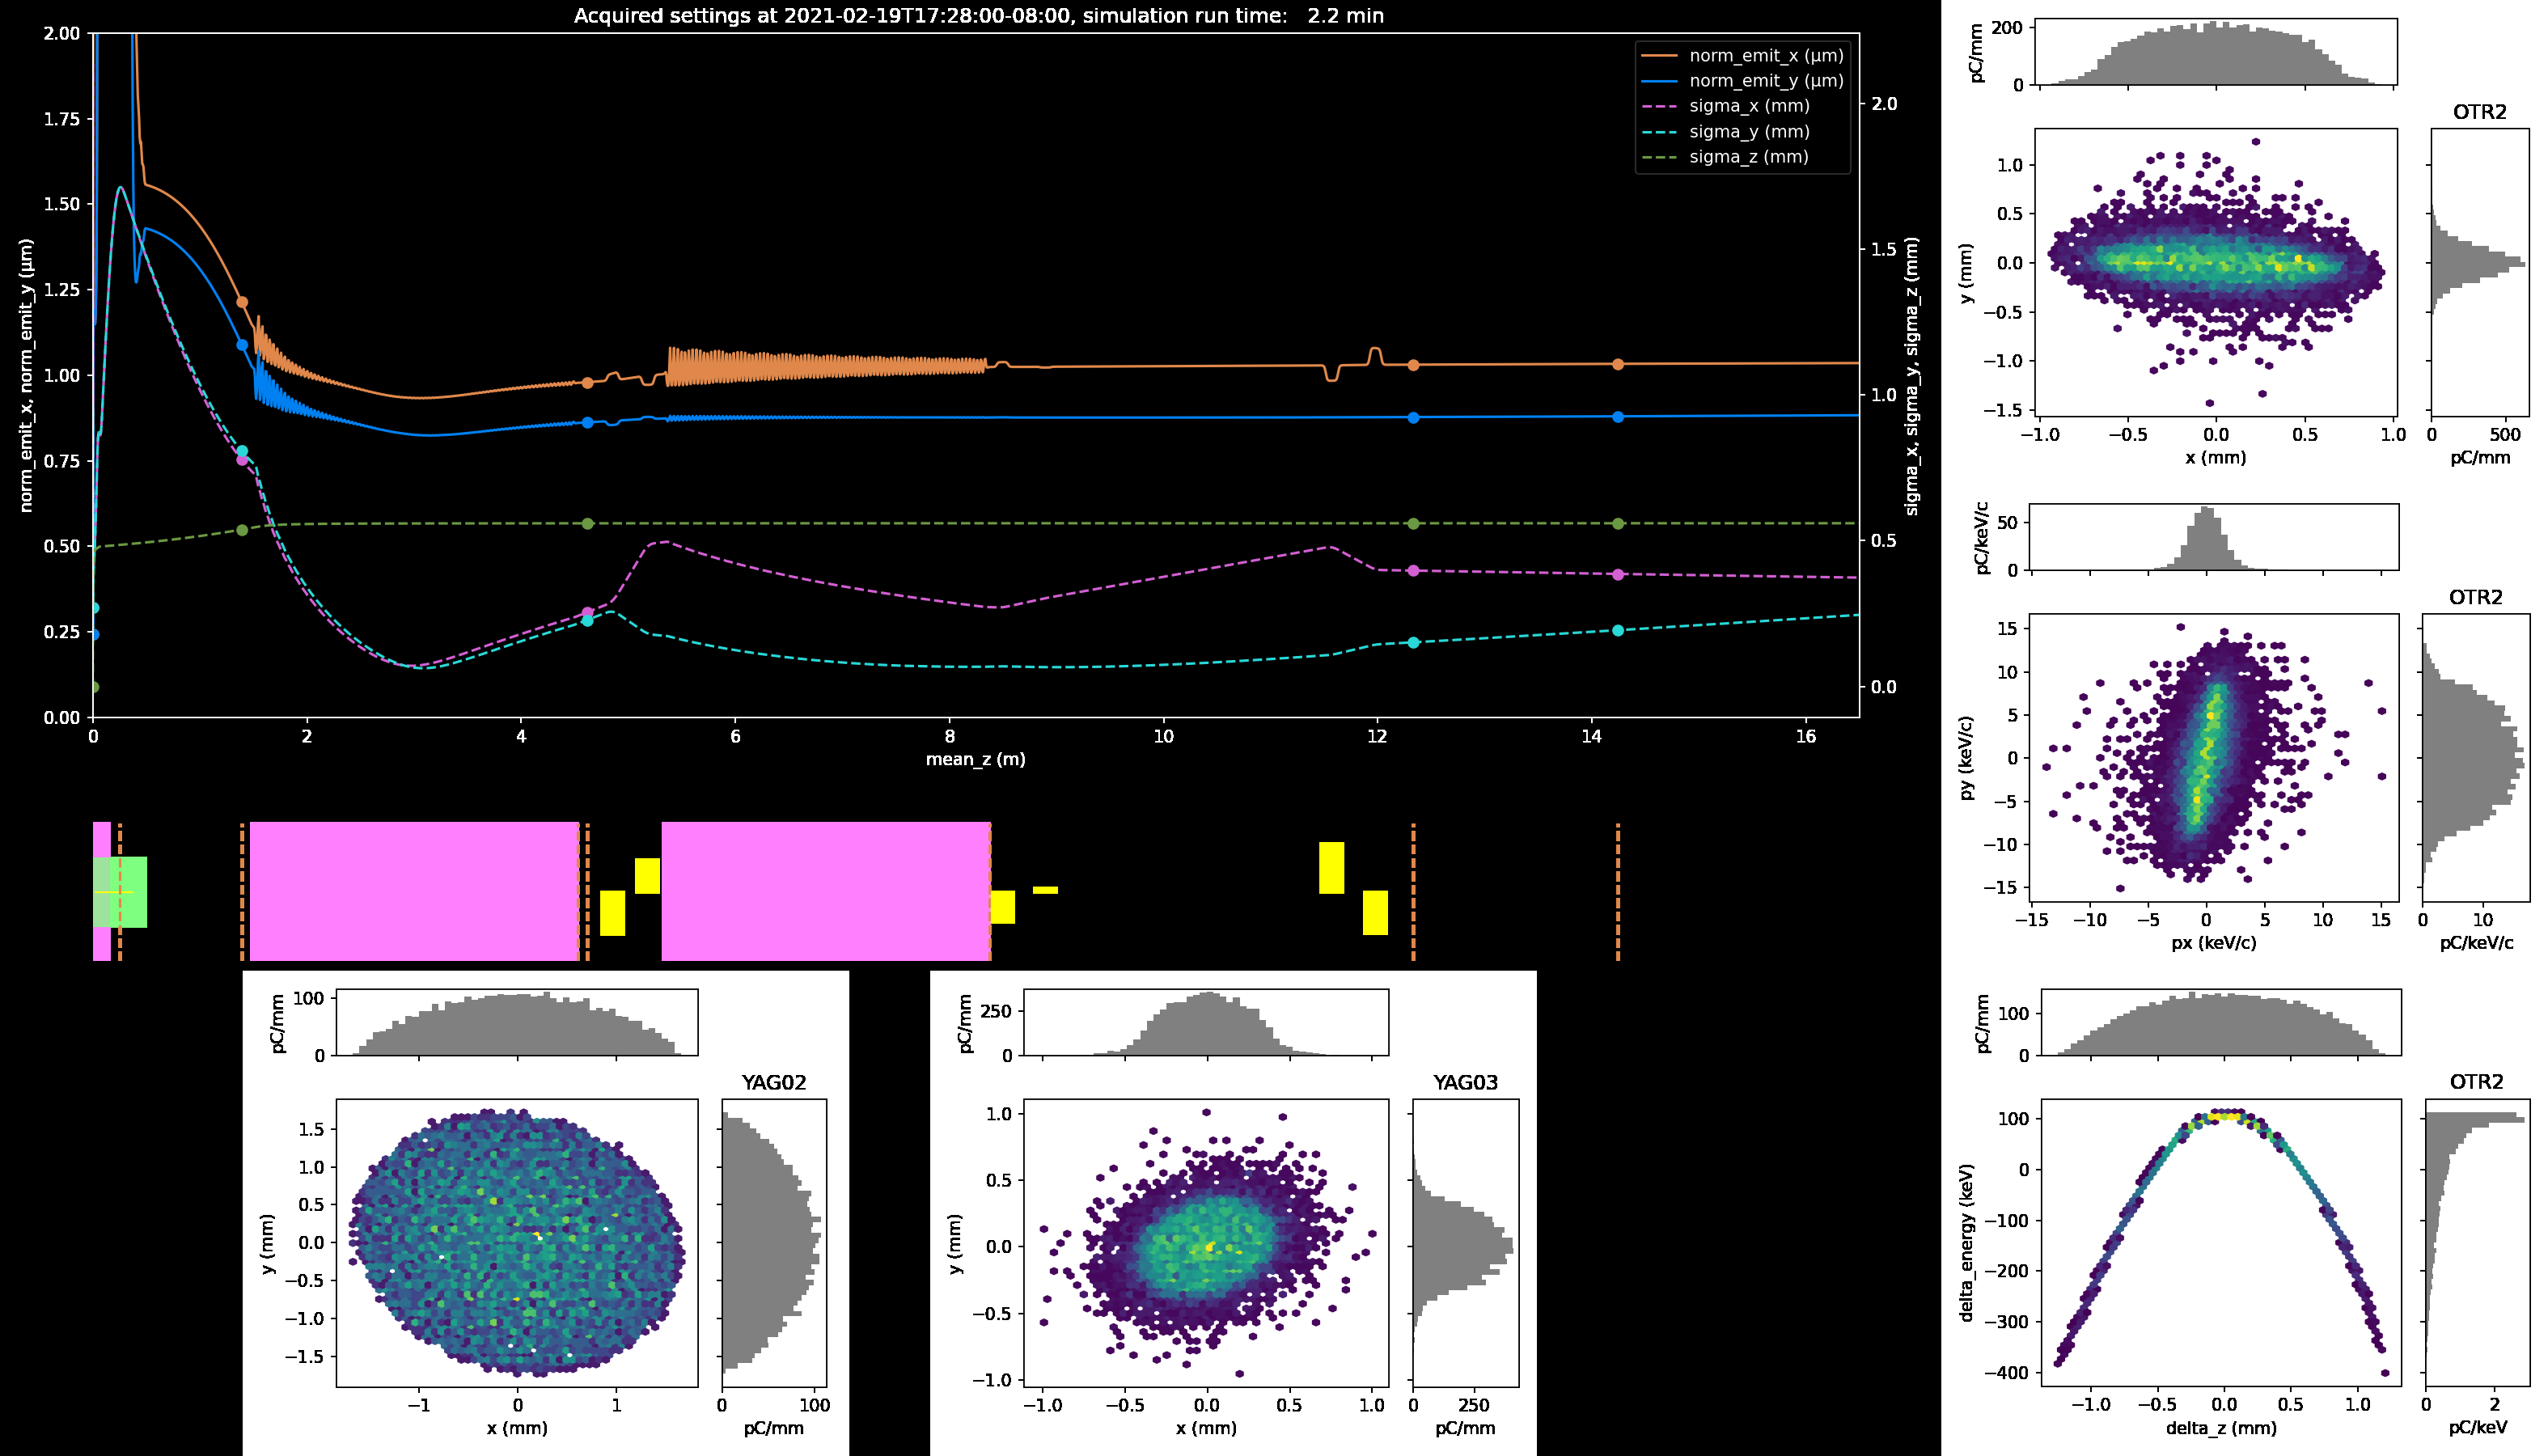

In [14]:
from IPython.display import Image
Image(filename=output['plot_file']) 

# loop it


In [15]:
#while True:
#    run1()